In [4]:
from PIL import Image, ImageOps
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import SGDClassifier

In [5]:
def aanmakenDf (groep, label):
#Drie lege lijsten worden aangemaakt die dan uiteindelijk samen dataframe zullen vormen 
    Pixels= []
    Label =[]
    Naam=[]
  
#fotos inlezen en omzetten per groep. 
    for foto in os.listdir(groep):
        beeld = Image.open(groep+foto)
#fotos omzetten in grijswaarde of 2 dimensionele array ipv 3x2
        beeld_grijs = ImageOps.grayscale(beeld)

#fotos resizen voor leesbaarheid tijdens testen, en eventueel voor latere experimenten
        beeld_formaat = beeld_grijs.resize((beeld_grijs.width // 8, beeld_grijs.height //8 ))       
        
#fotos omzetten naar numpy array
        data_2dim = np.asarray(beeld_formaat, dtype=np.uint8)
        data = data_2dim.flatten()

#3 lijsten opvullen, eerste met data van foto, tweede met label en derde met naam van foto. 
#De lengte van elke lijst = aantal fotos in bijhorende map
        Pixels.append(data)
        Label.append(label)
        Naam.append(foto)

#Per groep worden de drie aangemaakte lijsten omgezet naar panda df
    dict = {'data': Pixels, 'label': Label, 'naam': Naam}
    df = pd.DataFrame(dict)
    return df

In [6]:
aanwezig = r"classificatie/aanwezig/"  #852 foto's 
buiten = r"classificatie/buiten/"       #389 foto's
niets = r"classificatie/niets/"         #1399 foto's
#Eerst wordt per map een panda dataframe aangemaakt
nietsDf = aanmakenDf(niets, 0)
aanwezigDf = aanmakenDf(aanwezig, 1)
buitenDf = aanmakenDf(buiten, 2)
#vervolgens worden ze alle drie samengevoegd tot 1 groot dataframe
volledigDataframe = pd.concat([nietsDf, aanwezigDf, buitenDf], ignore_index=True)

In [7]:
#Opsplitsen in gestratificieerde testset en trainingsset
np.random.seed(42)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(volledigDataframe, volledigDataframe['label']):
    strat_train_set = volledigDataframe.loc[train_index]
    strat_test_set = volledigDataframe.loc[test_index] 
#X = data, y = label. Dit voor trainingsset en testset  
X_train, X_test, y_train, y_test, naam_train, naam_test = strat_train_set['data'], strat_test_set['data'], strat_train_set['label'], strat_test_set['label'], strat_train_set['naam'], strat_test_set['naam']

In [8]:
#Omzetten naar np.array
X_train_array = np.array(X_train.tolist())
X_test_array = np.array(X_test.tolist())
y_train_array = np.array(y_train)
y_test_array = np.array(y_test)
naam_train_array= np.array(naam_train)
naam_test_array= np.array(naam_test)

X_train_array.shape

(2112, 3520)

In [9]:
#Binaire classificatie
y_train_niets = (y_train_array == 0)
y_test_niets = (y_test_array == 0)

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train_array, y_train_niets)

(sgd_clf.predict([X_test_array[0]]))  
(sgd_clf.predict([X_test_array[2]]))  

array([False])

In [10]:
y_test_array[2]

2

In [11]:
#Cross Validatie: trainingsset opdelen in 3 delen
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train_array, y_train_niets, cv=3, scoring="accuracy")

array([0.87357955, 0.75852273, 0.87926136])

Cross validatie verwacht op basis van gokken is ongeveer 50´%

Bij aantal pixels gedeeld door 32, tussen 70 en 75% van gevallen correct

Bij aantal pixels gedeeld door 4, tussen 83 en 91% correct

Bij totale aantal pixels: tussen 83 en 92% correct (leertijd 35 sec, crossvalidatie tijd 92 sec)

In [12]:
#Cross validatie adhv confusion matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train_array, y_train_niets, cv=3)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_niets, y_train_pred)

array([[888, 105],
       [239, 880]], dtype=int64)

Confusion matrix bij totaal aantal pixels:

[[854, 139],

 [150, 969]]

Confusion matrix bij aantal pixels/4:

[[ 758,  235],

[  52, 1067]]

Hier: (zou eigenlijk beter omgekeerd...)

positief als er geen kat wordt herkend en er ook effectief geen is (true)

negatief als er wel een kat wordt herkend en er ook effectief een is (false)

vals negatief: kat is er niet, maar algoritme zegt van wel

vals positief: kat is er wel, maar algoritme denkt van niet

Hier dus vooral te vermijden: vals positief!!! Precision wordt verhoogd door de vals positieve te verlagen


In [13]:
#Precision en Recall
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_niets, y_train_pred) 

0.8934010152284264

In [14]:
recall_score(y_train_niets, y_train_pred)

0.7864164432529044

In [15]:
from sklearn.metrics import f1_score
f1_score(y_train_niets, y_train_pred)

0.8365019011406843

Treshold kan worden opgeschoven naar meer precision:  Precision Recall curve

In [16]:
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(sgd_clf, X_train_array, y_train_niets, cv=3,
method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_niets, y_scores)

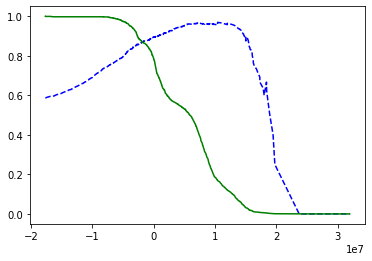

In [17]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [18]:
#Kiezen van mate van precisie. Hier kan mee worden gespeeld.
#Op basis hiervan bepalen hoeveel foto's uit analyse worden verwijderd...???
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

732846.903600606

In [19]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_niets, y_train_pred_90)

0.9001148105625718

In [20]:
recall_score(y_train_niets, y_train_pred_90)

0.7006255585344057

In [21]:
f1_score(y_train_niets, y_train_pred_90)

0.7879396984924623

In [22]:
#Multiclass classificatie 
#OvA classifier
sgd_clf_multi = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf_multi.fit(X_train_array, y_train_array)  

SGDClassifier(random_state=42)

In [23]:
(sgd_clf_multi.predict([X_test_array[3]]))

array([1], dtype=int64)

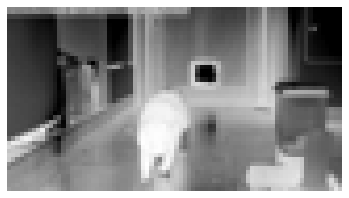

In [24]:
image = X_test_array[3].reshape(44,80)
plt.imshow(image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [25]:
y_test_array[3]

1

In [26]:
naam_test_array[3]

'20220213_114628.jpg'

In [27]:
some_digit_scores = sgd_clf_multi.decision_function([X_test_array[3]])
some_digit_scores

array([[-2872270.38507496,  3561173.81377103, -3157009.90567823]])

In [28]:
#cross validatie: verwachte score is 33%
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf_multi, X_train_array, y_train_array, cv=3, scoring="accuracy")

array([0.890625  , 0.86647727, 0.87926136])

In [29]:
#OvO classifier
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train_array, y_train_array)

OneVsOneClassifier(estimator=SGDClassifier(random_state=42))

In [30]:
ovo_clf.predict([X_test_array[3]])

array([1], dtype=int64)

In [31]:
#aantal schatters: verwacht 3x2/2
len(ovo_clf.estimators_)

3

In [32]:
from sklearn.model_selection import cross_val_score
cross_val_score(ovo_clf, X_train_array, y_train_array, cv=3, scoring="accuracy")

array([0.90056818, 0.80397727, 0.83096591])

In [33]:
#RandomforestClassifier
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train_array, y_train_array)

RandomForestClassifier(random_state=42)

In [34]:
forest_clf.predict([X_test_array[3]])

array([1], dtype=int64)

In [35]:
forest_clf.predict_proba([X_test_array[3]])

array([[0.02 , 0.795, 0.185]])

In [36]:
from sklearn.model_selection import cross_val_score
cross_val_score(forest_clf, X_train_array, y_train_array, cv=3, scoring="accuracy")

array([0.93465909, 0.93892045, 0.9375    ])

In [37]:
#Confusion matrix voor forestClassifier
#rijen zijn gegeven klasses, kolommen voorspelde
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_forestPred = cross_val_predict(forest_clf, X_train_array, y_train_array, cv=3)
conf_mx = confusion_matrix(y_train_array, y_train_forestPred)
conf_mx

array([[1108,   10,    1],
       [  50,  600,   32],
       [   3,   37,  271]], dtype=int64)

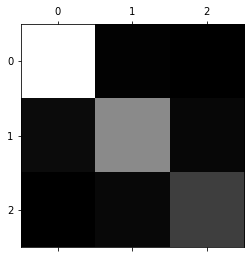

In [38]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

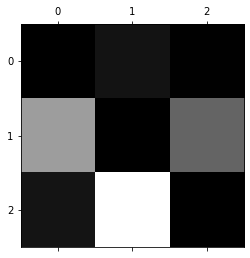

In [39]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or

OpenCV) to make some patterns stand out more, such as closed loops.

Analyzing individual errors can also be a good way to gain insights on what your

classifier is doing and why it is failing, but it is more difficult and time-consuming.

Bij ons kan vooral aanwezig of buiten scherper worden gesteld (Wit vak is eigenlijk geclassificeerd onder buiten, maar wordt voorspeld als aanwezig...)

In [40]:
#Votingclassifier toevoegen? 
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators=[('forest', forest_clf), ('ovo', ovo_clf), ('ova', sgd_clf_multi)],voting='hard')
voting_clf.fit(X_train_array, y_train_array)

VotingClassifier(estimators=[('forest',
                              RandomForestClassifier(random_state=42)),
                             ('ovo',
                              OneVsOneClassifier(estimator=SGDClassifier(random_state=42))),
                             ('ova', SGDClassifier(random_state=42))])

In [41]:
voting_clf.predict([X_test_array[3]])

array([1], dtype=int64)

In [42]:
cross_val_score(voting_clf, X_train_array, y_train_array, cv=3, scoring="accuracy")

array([0.91761364, 0.88068182, 0.890625  ])

In [43]:
from sklearn.metrics import accuracy_score
for clf in (sgd_clf_multi, ovo_clf, forest_clf, voting_clf):
 clf.fit(X_train_array, y_train_array)
 y_pred = clf.predict(X_test_array)
 print(clf.__class__.__name__, accuracy_score(y_test_array, y_pred))

SGDClassifier 0.9109848484848485
OneVsOneClassifier 0.8674242424242424
RandomForestClassifier 0.9450757575757576
VotingClassifier 0.9393939393939394


Alle Pixels

  SGDClassifier 0.8560606060606061

  OneVsOneClassifier 0.9318181818181818

  RandomForestClassifier 0.9412878787878788
  
  VotingClassifier 0.9223484848484849



Pixels / 2

SGDClassifier 0.928030303030303

OneVsOneClassifier 0.9109848484848485

RandomForestClassifier 0.9431818181818182

VotingClassifier 0.9450757575757576

Pixels / 4

SGDClassifier 0.7973484848484849

OneVsOneClassifier 0.7215909090909091

RandomForestClassifier 0.9450757575757576

VotingClassifier 0.9412878787878788

Pixels / 8

SGDClassifier 0.9109848484848485

OneVsOneClassifier 0.8674242424242424

RandomForestClassifier 0.9450757575757576

VotingClassifier 0.9393939393939394